In [50]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [51]:
import torch
from torch import Tensor, distributions

import matplotlib.pyplot as plt
import seaborn as sns

In this exercise, we'll look at how we can use distributions to form differentiable density-estimation methods. 

## Sampling
Let's first get a differentiable sample of points. Below, create two parameters, `concentration` and `rate`, both initialised at 2, and use these to instantiate a `Gamma` distribution.

In [52]:
# your code here(
concentration = torch.tensor([2.], requires_grad=True)
rate = torch.tensor([2.], requires_grad=True)

gam = distributions.Gamma(concentration = concentration, rate = rate)

Now sample 100 points from the `Gamma` into a tensor called `samples`.

In [61]:
# you code here

samples = gam.rsample(torch.Size([100]))
samples[:10]

tensor([[0.3802],
        [0.7507],
        [0.1937],
        [0.3014],
        [0.5919],
        [0.4406],
        [0.8831],
        [2.1530],
        [1.0734],
        [2.5210]], grad_fn=<SliceBackward0>)

In [62]:
assert torch.autograd.grad(samples.mean(), concentration, retain_graph=True)[0].abs() > 0

## KDE
Now we'll plot their KDE (kernel density estimate). This is done using a standard method, which doesn't account for the gradient function on the samples.

<AxesSubplot: ylabel='Density'>

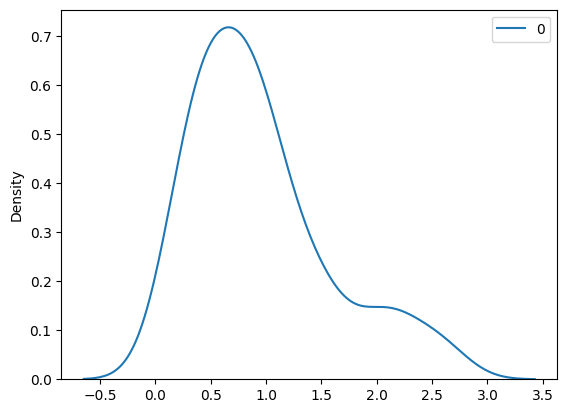

In [63]:
sns.kdeplot(samples.detach())

Now we'll create our own, differentiable KDE for our sample. KDEs are formed by seeding Gaussians of a set scale (bandwidth) at each point in the sample, and taking their mean PDF at a range of points.

Below compute the KDE values, `y`, using a `Normal` distribution, for a range of points, `x`, for the given bandwidth.

In [64]:
bandwidth = 0.25
x = torch.linspace(0,4, 50)

In [65]:
# Your code here

gausses = distributions.Normal(loc= samples, scale=bandwidth) # This creates 100 Gaussians, each centred on a different sample

In [66]:
y = gausses.log_prob(x).exp().mean(0)  # This computes the mean PDF for each point in x

In [67]:
assert y.shape==torch.Size([50])
assert torch.autograd.grad(y.mean(), concentration, retain_graph=True)[0].abs() > 0

And now we'll plot them below. The result should be similar to the plot above.

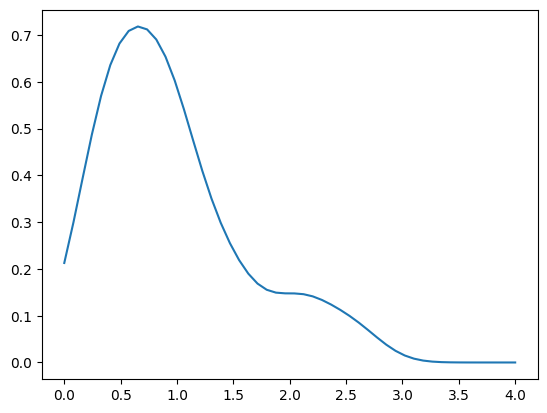

In [68]:
plt.plot(x,y.detach())

## Histogram
Quite often in HEP, and other fields, we like to work with histograms, but in the standard implementation, the bin fills are not differentiable: samples either lie in a given bin and contribute 1 to the bin population, or lie outside and contribute 0.

Using our `Normal` distribution, it becomes possible to compute a differentiable histogram. Have a think about how to do this (hint: use the `.cdf` method).

In [69]:
# your code here

bin_fills = (gausses.cdf(x[1:])-gausses.cdf(x[:-1])).mean(0)  # This integrates the Gaussians between the bin-edges in x, and then takes the mean fill per bin

In [70]:
assert torch.autograd.grad(bin_fills.mean(), concentration, retain_graph=True)[0].abs() > 0

<BarContainer object of 49 artists>

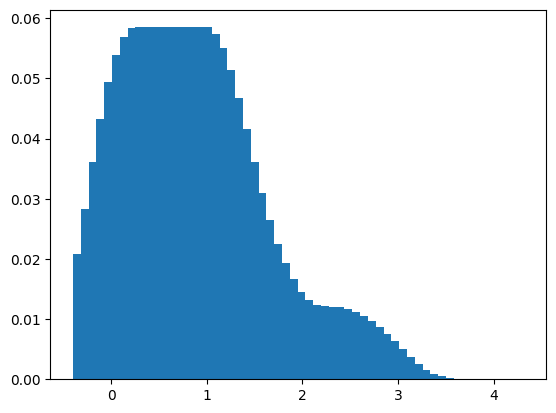

In [71]:
plt.bar(x[:-1], bin_fills.detach())